# Sampling from a GP

## Preliminary steps

### Loading necessary packages

In [1]:
using Plots
using AugmentedGaussianProcesses
using Distributions
using LinearAlgebra

### Loading the banana dataset from OpenML

In [2]:
kernel = SqExponentialKernel()
x = range(0, 10, length=50)
K = kernelmatrix(kernel, x)
f = rand(MvNormal(K + 1e-8I)) # Sample a random GP
y = rand.(Bernoulli.(AGP.logistic.(f)))
y_sign = sign.(y .- 0.5)

50-element Vector{Float64}:
  1.0
  1.0
 -1.0
  1.0
  1.0
  1.0
 -1.0
 -1.0
  1.0
  1.0
  ⋮
  1.0
 -1.0
  1.0
 -1.0
 -1.0
  1.0
 -1.0
 -1.0
  1.0

### We create a function to visualize the data

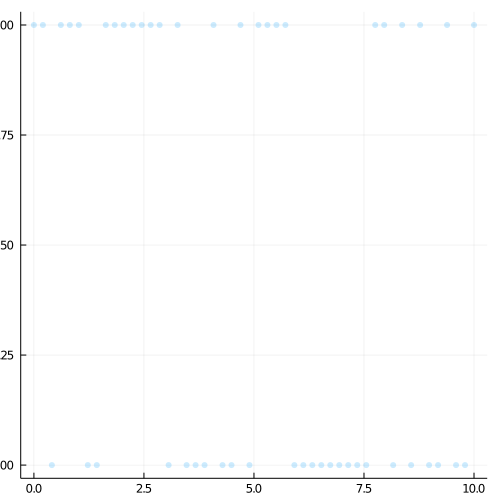

In [3]:
function plot_data(x, y; size=(300,500))
    Plots.scatter(x,
                y,
                alpha=0.2,
                markerstrokewidth=0.0,
                lab="",
                size=size
            )
end
plot_data(x, y; size = (500, 500))

### Run the variational gaussian process approximation

In [4]:
@info "Running full model"
mfull = VGP(x, y_sign,
            kernel,
            LogisticLikelihood(),
            AnalyticVI(),
            optimiser = false
            )
@time train!(mfull, 5)

[ Info: Running full model
  0.732142 seconds (1.15 M allocations: 67.507 MiB, 99.39% compilation time)


### We can also create a sampling based model

In [5]:
@info "Sampling from model"
mmcmc = MCGP(x, y,
            kernel,
            LogisticLikelihood(),
            GibbsSampling(),
            optimiser = false
            )
m = mmcmc
@time samples = sample(mmcmc, 1000)

[ Info: Sampling from model
Sampling with Gibbs Sampler   0%|                       |  ETA: N/A
Sampling with Gibbs Sampler   0%|▏                      |  ETA: 0:06:03
Sampling with Gibbs Sampler   1%|▎                      |  ETA: 0:03:05
Sampling with Gibbs Sampler   1%|▍                      |  ETA: 0:02:03
Sampling with Gibbs Sampler   2%|▍                      |  ETA: 0:01:32
Sampling with Gibbs Sampler   2%|▌                      |  ETA: 0:01:13
Sampling with Gibbs Sampler   3%|▋                      |  ETA: 0:01:01
Sampling with Gibbs Sampler   3%|▊                      |  ETA: 0:00:52
Sampling with Gibbs Sampler   4%|▉                      |  ETA: 0:00:45
Sampling with Gibbs Sampler   4%|█                      |  ETA: 0:00:40
Sampling with Gibbs Sampler   5%|█                      |  ETA: 0:00:36
Sampling with Gibbs Sampler   5%|█▏                     |  ETA: 0:00:33
Sampling with Gibbs Sampler   5%|█▎                     |  ETA: 0:00:30
Sampling with Gibbs Sampler   6%|█▍     

1000-element Vector{Vector{Vector{Float64}}}:
 [[0.7982322313632949, 0.6855664352428367, 0.5372597613666718, 0.4385097336897132, 0.3593366026826161, 0.37263482280604765, 0.44210033275408983, 0.539793957870912, 0.663235980284641, 0.7724730134557455  …  -0.4447571894497172, -0.5846320288234639, -0.7884548429887739, -1.00818747348269, -1.1835902541450083, -1.2450526371535275, -1.1743275529539945, -1.0011017950353582, -0.7074657053095235, -0.36449125892043]]
 [[0.9991070693507262, 1.3307311316538875, 1.7061956694339866, 2.0097957134141966, 2.216874163336673, 2.330936993865449, 2.314605115895217, 2.1658383435879265, 1.9119201741594134, 1.6009007618351365  …  0.06583279817500548, 0.05029494408110591, -0.08486804734592829, -0.30824625804282724, -0.5730253206299117, -0.855177368726381, -1.1215455542348076, -1.3848350042187225, -1.5398557714889403, -1.5859825492300272]]
 [[0.581994865686257, 0.620537163286583, 0.5883258960394353, 0.4340024991733843, 0.3177875016267765, 0.18350925511814464, 0.14

### We can now visualize the results of both models

### We first plot the latent function f (truth, the VI estimate, the samples)

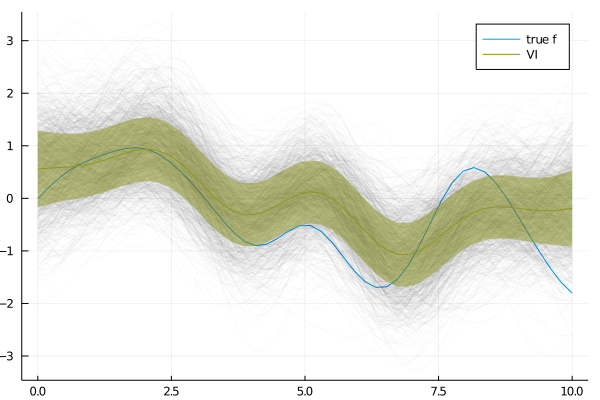

In [6]:
p1 = plot(x, f, label="true f")
plot!(x, samples, label="", color=:black, alpha=0.02, lab="")
plot!(x, mean(mfull[1]), ribbon=sqrt.(var(mfull[1])), label="VI")

### And we can also plot the predictions vs the data

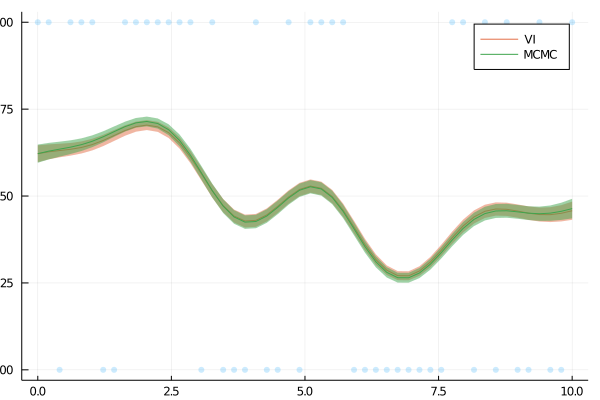

In [7]:
p2 = plot_data(x, y; size=(600,400))
μ_vi, σ_vi = proba_y(mfull, x)
plot!(x, μ_vi; ribbon=σ_vi, label="VI")
μ_mcmc, σ_mcmc = proba_y(mmcmc, x)
plot!(x, μ_mcmc; ribbon=σ_mcmc, label="MCMC")

---

*This notebook was generated using [Literate.jl](https://github.com/fredrikekre/Literate.jl).*